In [1]:
from Functions import *
from DataDefined import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [13]:

df = pd.read_csv('Driving Data(KIA SOUL)_(150728-160714)_(10 Drivers_A-J).csv')


drivers = df['Class'].unique()
for driver in drivers:
    time_seconds = len(df[df['Class'] == driver])
    time_minutes = time_seconds/60
    print(driver, time_minutes)

A 120.66666666666667
D 220.73333333333332
B 214.4
C 125.0
I 130.13333333333333
J 148.4
H 164.66666666666666
G 124.86666666666666
F 183.53333333333333
E 140.6


In [2]:
df = pd.read_csv('Driving Data(KIA SOUL)_(150728-160714)_(10 Drivers_A-J).csv')

df, label_mappings = preprocessing(df, one_val_col, irrelevant_col, to_be_scaled_col, two_val_col, some_val_num_col, some_val_cat_col)

In [8]:
time_seconds = len(df)
print(time_seconds)

94380


In [10]:
time_hours = time_seconds/3600
print(time_hours)

26.216666666666665


In [12]:
#Time in hours per driver
drivers = df['Class'].unique()
for driver in drivers:
    time_seconds = len(df[df['Class'] == driver])
    time_minutes = time_seconds/60
    print(driver, time_minutes)

A 120.66666666666667
D 220.73333333333332
B 214.4
C 125.0
I 130.13333333333333
J 148.4
H 164.66666666666666
G 124.86666666666666
F 183.53333333333333
E 140.6


In [19]:
encoder = LabelEncoder()
df['Class'] = encoder.fit_transform(df['Class'])
print(encoder.classes_, encoder.transform(encoder.classes_))

#df = add_derivatives(df, delta_col)

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J'] [0 1 2 3 4 5 6 7 8 9]


In [20]:
class_features = ['Class', 'Ride number', 'Time(s)']
rel_class_features = relevant_features + class_features
df = df[rel_class_features]
df = add_derivatives(df, delta_col)
df.columns

Index(['Accelerator_Pedal_value', 'Vehicle_speed',
       'Acceleration_speed_-_Longitudinal', 'Acceleration_speed_-_Lateral',
       'Indication_of_brake_switch_ON/OFF', 'Steering_wheel_speed',
       'Steering_wheel_angle', 'Master_cylinder_pressure', 'Fuel_consumption',
       'Flywheel_torque', 'Class', 'Ride number', 'Time(s)',
       'Steering_wheel_speed_derivative', 'Accelerator_Pedal_value_derivative',
       'Vehicle_speed_derivative'],
      dtype='object')

In [21]:
from sklearn.utils import shuffle

def get_next_index(i, j, size):
    new_index = j+i
    if new_index > (size-1):
        return new_index-(size-1)
    else:
        return new_index

def make_pairs_one_class(X, y, iterations):
    X = X.to_numpy()
    y = y.to_numpy()
    X_sameclass = []
    y_sameclass = []
    for i in range(0, iterations):
        for j in range(0, len(X)):
            index = get_next_index(i, j, len(X))
            X_sameclass.append(X[j] + X[index])
            y_sameclass.append(int(y[j] == y[index]))

    X_pairwise_shuffled, y_pairwise_shuffled = shuffle(X_sameclass, y_sameclass, random_state=42)


    return X_pairwise_shuffled, y_pairwise_shuffled

def make_pairs_two_classes(df_driver1, df_driver2, iterations):
    # What I'm getting:
    # df_driver1: (train_df, test_df, of train_df) class B
    # df_driver2: Class D (OOD)

    # What I want:
    # Combinations of B-B and B-D/D-B

    ## split X into two 
    X_1, y_1 = split_into_X_and_y(df_driver1)
    X_2, y_2 = split_into_X_and_y(df_driver2)

    X_bb, y_bb = make_pairs_one_class(X_1, y_1, iterations)

    X_1 = X_1.to_numpy()
    y_1 = y_1.to_numpy()
    X_2 = X_2.to_numpy()
    y_2 = y_2.to_numpy()

    #### make combination BD
    X_BD = []
    y_BD = []
    for i in range(0, iterations):
        for j in range (0, len(X_2)): #X_2 == D
            index = get_next_index(i, j, len(X_1))
            X_BD.append(X_2[j] + X_1[index])
            y_BD.append(int(y_2[j] == y_1[index]))

    X_pairwise = X_bb + X_BD
    y_pairwise = y_bb + y_BD

    #### shuffle X and y

    X_pairwise_shuffled, y_pairwise_shuffled = shuffle(X_pairwise, y_pairwise, random_state=42)

    return X_pairwise_shuffled, y_pairwise_shuffled

In [22]:
X_train, y_train, df_test1, df_test2, df_val1, df_val2 = splitDataForPairWise(df, 1, 3, 42)

In [23]:
## make pairs
X_train_pairs, y_train_pairs = make_pairs_one_class(X_train, y_train, 20)
X_test_pairs, y_test_pairs = make_pairs_two_classes(df_test1, df_test2, 10)
X_val_pairs, y_val_pairs = make_pairs_two_classes(df_val1, df_val2, 10)

In [24]:
print(len(X_train_pairs), len(X_test_pairs), len(X_val_pairs))

164240 46680 51840


### ONECLASS SVM

In [25]:
from sklearn.svm import SVC
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report

In [29]:
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)

oc_svm.fit(X_train_pairs, y_train_pairs)

OneClassSVM(gamma='auto', nu=0.1)

In [30]:
y_pred_test = oc_svm.predict(X_test_pairs)
print(y_pred_test[0:100])

print(y_test_pairs[0:100])

[ 1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1 -1 -1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1 -1 -1
  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 -1  1 -1 -1]
[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0]


In [31]:
#y_pred_test = oc_svm.predict(X_test_pairs)
#y_pred_train = oc_svm.predict(X_train_pairs)

y_pred_test = [0 if x == -1 else 1 for x in y_pred_test]
#y_pred_train = [0 if x == -1 else 1 for x in y_pred_train]

print(classification_report(y_test_pairs, y_pred_test))

              precision    recall  f1-score   support

           0       0.45      0.08      0.14     25680
           1       0.44      0.88      0.59     21000

    accuracy                           0.44     46680
   macro avg       0.45      0.48      0.36     46680
weighted avg       0.45      0.44      0.34     46680



### TABULARNN

In [32]:
CLASS_OOD = 0 #since D is the unknown class

In [33]:
# Convert to input for the model
X_train = torch.tensor(X_train_pairs, dtype=torch.float32)
X_test = torch.tensor(X_test_pairs, dtype=torch.float32)
X_val = torch.tensor(X_val_pairs, dtype=torch.float32)

y_train = torch.tensor(y_train_pairs, dtype=torch.long)
y_test = torch.tensor(y_test_pairs, dtype=torch.long)
y_val = torch.tensor(y_val_pairs, dtype=torch.long)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

# To evaluate, the OOD prediction should be compared
# Therefore, change class number that is OOD in the testset to -1
y_test_ood = torch.where(y_test == CLASS_OOD, -1, y_test)
y_val_ood = torch.where(y_val == CLASS_OOD, -1, y_val)

torch.Size([164240, 13])
torch.Size([46680, 13])
torch.Size([51840, 13])
torch.Size([164240])
torch.Size([46680])
torch.Size([51840])


C:\Users\miria\AppData\Local\Temp\ipykernel_15696\3377070900.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  X_train = torch.tensor(X_train_pairs, dtype=torch.float32)


In [60]:
class TabularNN(nn.Module):
    def __init__(self, input_dim):
        super(TabularNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64,64)
        self.fc5 = nn.Linear(64,64)
        self.fc6 = nn.Linear(64,64)
        self.fc7 = nn.Linear(64,64)
        self.fc8 = nn.Linear(64,64)
        self.fc9 = nn.Linear(64,32)  
        self.fc10 = nn.Linear(32,2)   # Output layer: 2 classes
        self.relu = nn.RReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.relu(self.fc7(x))
        x = self.relu(self.fc8(x))
        x = self.relu(self.fc9(x))
        x = self.fc10(x)
        return x

In [72]:
input_dim = X_train.shape[1]   
model = TabularNN(input_dim)
criterion = nn.CrossEntropyLoss()  # For multi-class classifications
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 60

In [73]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    predictions = model(X_train)  # Logits output
    loss = criterion(predictions, y_train)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Evaluate on test data
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)  # Logits
    # Convert logits to probabilities (using softmax) and get predicted class
    predicted_probs = torch.softmax(test_predictions, dim=1)
    max_probs, predicted_classes = torch.max(predicted_probs, dim=1)
    threshold = 0.999999   #0.999999 
    predicted_classes[max_probs < threshold] = -1  

# Normally, one would also calculate the test loss; however, now we have prediction -1, 
# so not sure how to handle that in the loss calculation 
print("Predicted Classes (with OOD detection):", predicted_classes)

Epoch 0, Loss: 0.6313
Epoch 10, Loss: 0.5354
Epoch 20, Loss: 0.2406
Epoch 30, Loss: 0.0000
Epoch 40, Loss: 0.0000
Epoch 50, Loss: 0.0000
Predicted Classes (with OOD detection): tensor([1, 1, 1,  ..., 1, 1, 1])


In [74]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_ood, predicted_classes)
print(cm)

[[    0 25680]
 [    0 21000]]


In [75]:
print(len(max_probs))

46680


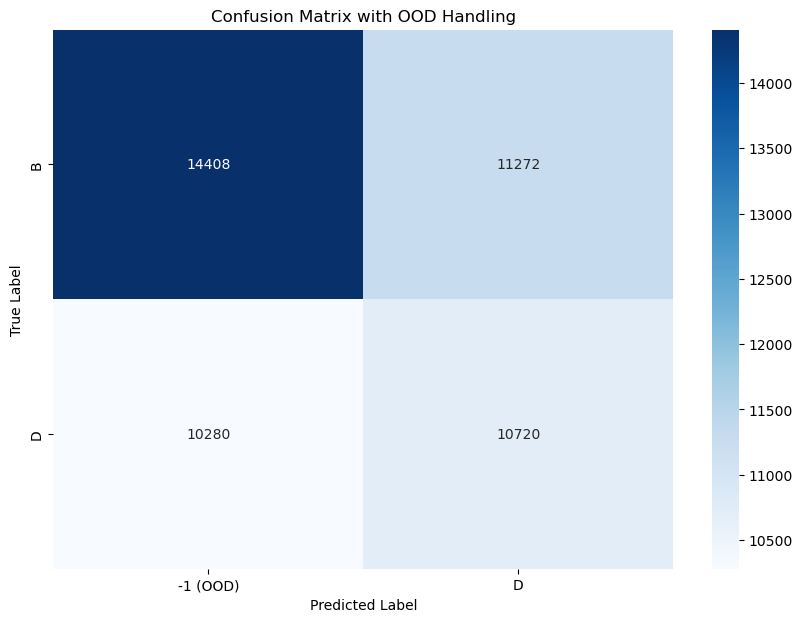

In [54]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_ood, predicted_classes)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels= ['-1 (OOD)',  'D', ], 
            yticklabels= ['B',  'D'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix with OOD Handling')
plt.show()

In [57]:
from sklearn import metrics
def calculate_ROC_AUC_score(y_test_ood, max_probs):
    """
    Calculates the ROC AUC score for a model based on its probability predictions 
    and the actual class labels (in or out of distribution).

    @param y_test_ood   tensor containing the actual class labels, where -1 represents out-of-distribution
    @param max_probs    tensor or array containing the model's probability predictions
    
    @return roc_auc_score_of_model  computed ROC AUC score as a float
    """
    # Convert OOD (-1) labels to 0, and in-distribution labels to 1
    x_true_values = torch.where(y_test_ood == -1, torch.tensor(0), torch.tensor(1))

    # Compute the ROC AUC score
    roc_auc_score_of_model = metrics.roc_auc_score(x_true_values.numpy(), max_probs.numpy())

    return roc_auc_score_of_model

In [76]:
print(metrics.roc_auc_score(y_test.numpy(), max_probs.numpy()))


0.5


In [55]:
print(classification_report(y_test_ood, predicted_classes))

              precision    recall  f1-score   support

          -1       0.58      0.56      0.57     25680
           1       0.49      0.51      0.50     21000

    accuracy                           0.54     46680
   macro avg       0.54      0.54      0.54     46680
weighted avg       0.54      0.54      0.54     46680



### LR System